# Classifying Tweets from Russian Trolls

This project aims to build a machine learning model that classifies tweets as coming from a Russian troll account, or from a verified user. 

Parts of this code were run in the cloud using [Google Colab](http://colab.research.google.com), due to the amount of processing power required. As a result, not all of the code in this notebook will run smoothly on a local machine. 

### Table of contents

[**Section I**](#Section-I:-Preprocessing-data-files): Preprocessing data files

[**Section II**](#Section-II:-Feature-Engineering-and-Text-Preprocessing): Feature Engineering and Text Preprocessing

[**Section III**](#Section-III:-Modelling): Modelling

[**Section IV**](#Section-IV:-Visualizations): Visualizations

In [3]:
from collections import Counter
from datetime import datetime
import json
# import jsonpickle
import os
import pickle
import re
import sys
import time

from bokeh.io import export_png
import bokeh.models as bmo
from bokeh.models import BoxSelectTool, DatetimeTickFormatter
import bokeh.plotting as bpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import FreqDist, word_tokenize
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
# import phantomjs
# import pillow
import preprocessor as p
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from wordcloud import WordCloud
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Joey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
%load_ext autoreload
%autoreload 1

sys.path.append("../../src/")

from d01_data.data_processing import *
from d02_features.text_preprocessing import *
from d03_models.modelling_functions import *
from d04_visualisation.building_charts import *

%aimport d01_data.data_processing
%aimport d02_features.text_preprocessing
%aimport d03_models.modelling_functions
%aimport d04_visualisation.building_charts

## Section I: Preprocessing data files

### Dataset #1: Russian troll tweets

Data source: [FiveThirtyEight](https://github.com/fivethirtyeight/russian-troll-tweets)

Process raw Russian tweets data into `RightTroll` subset, filtering down to rows and columns of interest

In [0]:
# process_files_into_right_trolls(num_of_files=13, chunksize=50000)
# create_combined_right_troll_csv(new_filepath='../../data/02_intermediate/right_trolls_all.csv')
# trim_right_trolls_csv(orig_filepath='../../data/02_intermediate/right_trolls_all.csv', 
#                        new_filepath='../../data/02_intermediate/right_trolls_trimmed.csv')

Read in `right_trolls_trimmed.csv`

In [0]:
# right_trolls = pd.read_csv('../../data/02_intermediate/right_trolls_trimmed.csv', parse_dates=[2])
# print(right_trolls.shape)
# right_trolls.head()

### Dataset #2: Verified tweets

Collected using [`twint`](https://github.com/twintproject/twint)

Process verified tweets collected using `twint` (queried using specific hashtags, and not) into one file

In [0]:
# create_verified_tweets_csv(new_filepath='../../data/02_intermediate/verified_tweets.csv')

Read in `verified_tweets.csv`

In [0]:
# verified_tweets = pd.read_csv('../../data/02_intermediate/verified_tweets.csv', parse_dates=[2])
# print(verified_tweets.shape)
# verified_tweets.head()

Issue with a lot of major accounts being followed...

In [0]:
# verified_tweets.author.value_counts().head(50)

### Combine datasets 

In [0]:
# create_tweets_all_csv(path_to_right_trolls='../../data/02_intermediate/right_trolls_trimmed.csv',
#                       path_to_verified_tweets='../../data/02_intermediate/verified_tweets.csv',
#                       new_filepath='../../data/02_intermediate/tweets_all.csv',
#                       random_state=123)

Read in `tweets_all.csv`

In [ ]:
# tweets_all = pd.read_csv('../../data/02_intermediate/tweets_all.csv', parse_dates=[2])
# print(tweets_all.shape)
# tweets_all.head()

## Section II: Feature Engineering and Text Preprocessing

#### Preprocessing

In [0]:
# tweets_all = add_clean_text_numeric_and_regex_features(tweets_all)

Original shape: (343582, 4)
New shape: (343582, 18)


#### Save `tweets_all_feats`

In [0]:
# tweets_all.to_pickle('../../data/02_intermediate/tweets_all_feats.pkl')

## Section III: Modelling

### Train test split

I want classes to be balanced in the *training* data, but I want to make the *testing* data to be artificially imbalanced (mimicking real world conditions)

In [0]:
# train, test, validate = validate_train_test_split(tweets_all, test_size=0.1, validation_size=0.2, random_state=123)

Train shape: (247378, 18)
Test shape: (34359, 18)
Validation shape: (61845, 18)


Define `X_train` and `y_train`

In [0]:
# X_train = train.drop(['target'], axis=True)
# y_train = train['target']

# print(X_train.shape)
# print(y_train.shape)

(247378, 17)
(247378,)


Define `X_test` and `y_test`

In [0]:
# X_test, y_test = generate_unbalanced_X_and_y(test, pos_class_size=0.1, random_state=123)

Original shape: (34359, 18)
X negative rows: (17215, 17)
X positive rows 10.0% sample: (1722, 17)
X new: (18937, 17)
y negative rows: (17215,)
y positive rows 10.0% sample: (1722,)
y new: (18937,)


Define `X_valid` and `y_valid`

In [0]:
# X_valid, y_valid = generate_unbalanced_X_and_y(validate, pos_class_size=0.1, random_state=123)

Original shape: (61845, 18)
X negative rows: (30883, 17)
X positive rows 10.0% sample: (3088, 17)
X new: (33971, 17)
y negative rows: (30883,)
y positive rows 10.0% sample: (3088,)
y new: (33971,)


### Create my final `X` dataset

Which will be a combination of 4 vectors:

1. word vector : `_content`
2. emoji vector : `_emoji`
3. hashtag vector : `_hashtag`
4. "counts" vector (of numeric data) : `_numeric`

#### Combine 4 vectors together into `X_train_combo` and `X_test_combo`

In [0]:
# X_train_combo, X_test_combo, X_valid_combo = generate_combined_features_X(X_train, X_test, X_valid)

Word vector
Train: (247378, 300)
Test: (18937, 300)
Valid: (33971, 300)
Emoji vector
Train: (247378, 200)
Test: (18937, 200)
Valid: (33971, 200)
Hashtag vector
Train: (247378, 300)
Test: (18937, 300)
Valid: (33971, 300)
Numeric vector
Train: (247378, 11)
Test: (18937, 11)
Valid: (33971, 11)
---X_train report---
(247378, 300)
(247378, 200)
(247378, 300)
(247378, 11)
Combined shape: (247378, 811)
---X_test report---
(18937, 300)
(18937, 200)
(18937, 300)
(18937, 11)
Combined shape: (18937, 811)
---X_valid report---
(33971, 300)
(33971, 200)
(33971, 300)
(33971, 11)
Combined shape: (33971, 811)


### Save X and y to `data/03_processed/`

In [0]:
# X_train_combo.to_pickle('../../data/03_processed/X_train.pkl')
# X_test_combo.to_pickle('../../data/03_processed/X_test.pkl')
# X_valid_combo.to_pickle('../../data/03_processed/X_validation.pkl')

# y_train.to_pickle('../../data/03_processed/y_train.pkl')
# y_test.to_pickle('../../data/03_processed/y_test.pkl')
# y_valid.to_pickle('../../data/03_processed/y_validation.pkl')

#### Save entire vocabulary (to use in making predictions with the web app)

In [0]:
vocab = list(X_train.columns)[:800]
len(vocab)

filepath = '../../data/04_models/training_vocabulary.pkl'
# with open(filepath, 'wb') as f:
#     vocab = pickle.dump(vocab, f)

# with open(filepath, 'rb') as f:
#     vocab = pickle.load(f)

## Modeling pipelines

Read in `X_train`, `X_test`, `y_train` and `y_test`

In [0]:
tweets_all = pd.read_pickle('../../data/03_processed/tweets_all_feats.pkl')

X_train = pd.read_pickle('../../data/03_processed/X_train.pkl')
X_test = pd.read_pickle('../../data/03_processed/X_test.pkl')
X_valid = pd.read_pickle('../../data/03_processed/X_validation.pkl')

y_train = pd.read_pickle('../../data/03_processed/y_train.pkl')
y_test = pd.read_pickle('../../data/03_processed/y_test.pkl')
y_valid = pd.read_pickle('../../data/03_processed/y_validation.pkl')

In [0]:
random_state = 123
pipe_lr = Pipeline([('clf', LogisticRegression(penalty='l2', random_state=random_state))])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(max_depth=5, random_state=random_state))])
pipe_rf = Pipeline([('clf', RandomForestClassifier(n_estimators=100, random_state=random_state))])
pipe_ab = Pipeline([('clf', AdaBoostClassifier(n_estimators=50, random_state=random_state))])

In [0]:
pipelines = [pipe_lr, pipe_dt, pipe_rf 
             , pipe_ab 
            ]
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest'
             , 3: 'AdaBoost'
            }

In [0]:
for pipe in pipelines:
    pipe.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Iterating through pipelines to find the best recall score

In [0]:
best_recall = 0.0
best_clf = 0
best_pipe = ''
cm = None
for idx, pipe in enumerate(pipelines):
    y_pred = pipe.predict(X_test)
    if recall_score(y_test, y_pred) > best_recall:
        best_recall = recall_score(y_test, y_pred)
        best_pipe = pipe
        best_clf = idx
        cm = confusion_matrix(y_test, y_pred)
print('Classifier with best recall:', pipe_dict[best_clf])
print('Recall:', best_recall)
print('Confusion matrix')
print(cm)

Classifier with best recall: Random Forest
Recall: 0.9047619047619048
Confusion matrix
[[16143  1072]
 [  164  1558]]


Baseline

In [0]:
y_test.value_counts(normalize=True)

0    0.909067
1    0.090933
Name: target, dtype: float64

#### Comparison across estimators

In [0]:
estimators = []
f1_scores = []
recall_scores = []

for idx, pipe in enumerate(pipelines):
    y_pred = pipe.predict(X_test)
    print(f'{pipe_dict[idx]} pipeline')
    print('  F1 score:', f1_score(y_test, y_pred))
    print('  Recall score:', recall_score(y_test, y_pred))
    estimators.append(pipe_dict[idx])
    f1_scores.append(f1_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))

Logistic Regression pipeline
  F1 score: 0.5822930670251584
  Recall score: 0.8803716608594657
Decision Tree pipeline
  F1 score: 0.6279069767441862
  Recall score: 0.5644599303135889
Random Forest pipeline
  F1 score: 0.7159926470588236
  Recall score: 0.9047619047619048
AdaBoost pipeline
  F1 score: 0.5084745762711864
  Recall score: 0.818815331010453


#### KNN

In [0]:
scores = []
for k in range(1, 36):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(recall_score(y_test, y_pred))

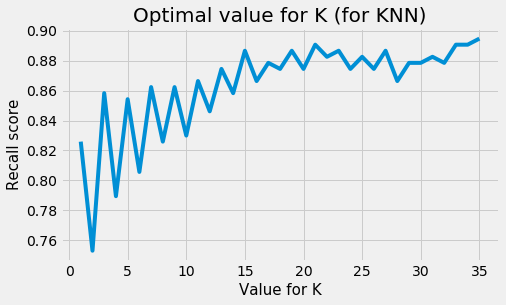

In [0]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.plot(range(1, 36), scores)
ax.set_title('Optimal value for K (for KNN)', size=20)
ax.set_xlabel('Value for K', size=15)
ax.set_ylabel('Recall score', size=15);

In [0]:
knn = KNeighborsClassifier(n_neighbors=21)  # k=21 looks the best
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
recall_score(y_test, y_pred)

In [0]:
knn = KNeighborsClassifier()  # baseline knn model
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
recall_score(y_test, y_pred)

estimators.append('KNN')
f1_scores.append(f1_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))

#### XGBoost

In [0]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

estimators.append('XGBoost')
f1_scores.append(f1_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))

recall: 0.8042973286875726
f1: 0.5603884280801134


#### Comparison dataframe


In [0]:
model_comparison = pd.DataFrame({'estimator': estimators, 'f1_score': f1_scores, 
              'recall_score': recall_scores})
model_comparison

estimator  f1_score  recall_score
0  Logistic Regression  0.582293      0.880372
1        Decision Tree  0.627907      0.564460
2        Random Forest  0.715993      0.904762
3             AdaBoost  0.508475      0.818815
4              XGBoost  0.560388      0.804297

In [0]:
# model_comparison.to_csv('../../data/05_model_output/model_comparison.csv', index=False)

#### Comparing results across estimators

Saved ../../results/img/04_model_comparison-testestest.png


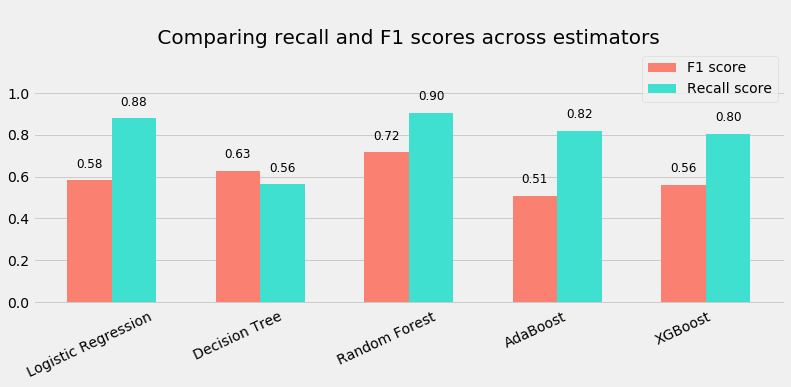

In [8]:
plot_model_comparison(path_to_data='../../data/05_model_output/model_comparison.csv',
                      new_filepath='../../results/img/04_model_comparison-testestest.png')

#### Hyperparameter tuning for Random Forest

In [0]:
pipe_rf_empty = Pipeline([('clf', RandomForestClassifier())])

# Set grid search params
params = [ 
  {'clf__n_estimators': [10, 30, 50],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[1, 3, 5, 10],  
   'clf__min_samples_split':[2, 3, 5, 10],
   'clf__random_state':[123]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf_empty,
            param_grid=params,
            scoring='recall',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best recall
print('Best recall:', gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123, total=   2.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123, total=   2.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=10, clf__random_state=123, total=   2.0s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=30, clf__random_state=123 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=30, clf__random_state=123, total=   3.8s
[CV] clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=30, clf__random_state=123 
[CV]  clf__criterion=entropy, clf__max_depth=4, clf__min_samples_leaf=1, clf__min_samples_split=2

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed: 70.4min finished


Best recall: 0.9296357713174214

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 10, 'clf__random_state': 123}


In [0]:
best_rf = gs_rf.best_estimator_.steps[0][1]
best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

Save the best random forest model as a `.pkl`

In [0]:
# joblib.dump(best_rf, 'drive/My Drive/data/best_rf_all_data_20190906.pkl', compress=1)

['drive/My Drive/data/best_rf_all_data_20190906.pkl']

#### Load best RF model

In [26]:
best_rf = joblib.load('drive/My Drive/data/best_rf_all_data_20190906.pkl')
best_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [29]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
recall_score(y_test, y_pred)

0.9332171893147503

In [30]:
confusion_matrix(y_test, y_pred)

array([[10648,  6567],
       [  115,  1607]])

#### Investigate mismatchs

In [0]:
comparison_df = pd.DataFrame({'y_actual' : y_test, 'y_predicted' : y_pred})

In [0]:
mismatch_df = comparison_df[comparison_df['y_actual'] != comparison_df['y_predicted']]
print(mismatch_df.shape)
mismatch_df.head()

(6682, 2)


y_actual  y_predicted
251479         0            1
290153         0            1
201813         0            1
228023         0            1
319736         0            1

In [0]:
115 + 6567  # check looks good

6682

In [0]:
orig_tweets = tweets_all.iloc[mismatch_df.index, :][['author', 'content', 'publish_date', 'target']]
orig_tweets.head()

author  ... target
251479    thebillswire  ...      0
290153     curtishouck  ...      0
201813       bighugh53  ...      0
228023  kristerjohnson  ...      0
319736    campusreform  ...      0

[5 rows x 4 columns]

In [0]:
mismatch_df_orig_tweets = pd.merge(orig_tweets, mismatch_df, how='left', left_index=True, right_index=True)
mismatch_df_orig_tweets.shape

(6682, 6)

3 example false negative tweets

In [0]:
mismatch_df_orig_tweets[mismatch_df_orig_tweets.y_predicted == 0].loc[[131929, 11605, 82681]]#.content.values  # 11605, 

author  ... y_predicted
131929          TEN_GOP  ...           0
11605   COVFEFENATIONUS  ...           0
82681      RYANAMBISHOP  ...           0

[3 rows x 6 columns]

In [0]:
# mismatch_df_orig_tweets.to_csv('drive/My Drive/data/mismatches.csv', index=False)

#### Append predicted classes and probabilities to original tweet

In [31]:
predictions = pd.DataFrame({'y_actual' : y_test, 'y_pred' : y_pred, 'y_pred_proba' : y_pred_proba})
print(predictions.shape)
predictions.head()

(18937, 3)


y_actual  y_pred  y_pred_proba
325374         0       0      0.309641
251479         0       1      0.503133
174200         0       0      0.491662
197848         0       0      0.345173
290153         0       1      0.503133

In [32]:
orig_tweets = tweets_all.iloc[predictions.index, :][['author', 'content', 'publish_date', 'target']]
print(orig_tweets.shape)
orig_tweets.head()

(18937, 4)


author  ... target
325374  rebelnewsonline  ...      0
251479     thebillswire  ...      0
174200   irishsunonline  ...      0
197848     boardingarea  ...      0
290153      curtishouck  ...      0

[5 rows x 4 columns]

In [33]:
predictions_orig_tweets = pd.merge(orig_tweets, predictions, how='left', left_index=True, right_index=True)
print(predictions_orig_tweets.shape)
predictions_orig_tweets.head()

(18937, 7)


author  ... y_pred_proba
325374  rebelnewsonline  ...     0.309641
251479     thebillswire  ...     0.503133
174200   irishsunonline  ...     0.491662
197848     boardingarea  ...     0.345173
290153      curtishouck  ...     0.503133

[5 rows x 7 columns]

In [0]:
# predictions_orig_tweets.to_csv('drive/My Drive/data/predictions.csv', index=True, index_label='idx')

#### Prettify confusion matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, filepath,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    # save fig
    plt.savefig(filepath)
    
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[10648  6567]
 [  115  1607]]


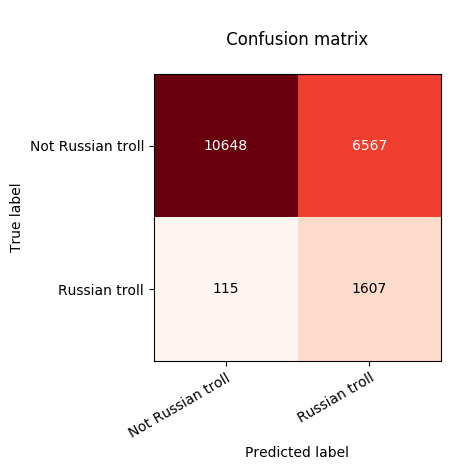

In [0]:
plt.style.use('default')
plot_confusion_matrix(y_test, y_pred, classes=['Not Russian troll', 'Russian troll'],
                      title='\n Confusion matrix \n',
                      filepath='drive/My Drive/data/05_confusion_matrix_rf.png')

Look at feature importances

In [0]:
feat_importance = pd.DataFrame((zip(X_train.columns, best_rf.feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.4f' % x) 
feat_importance.sort_values('importance', ascending=False).head(10)

feature_name importance
810      pics_count     0.1828
264           trump     0.1381
806       pct_upper     0.1230
802  hashtags_count     0.1183
217              rt     0.0790
22            break     0.0656
774          #trump     0.0225
96        happy new     0.0222
801  mentions_count     0.0214
274           video     0.0192

#### Best Random Forest parameters from first grid search

In [0]:
rforest = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=5,
                                 min_samples_leaf=1, min_samples_split=2
                                , random_state=123
                                )
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
recall_score(y_test, y_pred)

0.9332171893147503

In [0]:
confusion_matrix(y_test, y_pred)

array([[10648,  6567],
       [  115,  1607]])

In [0]:
scores_rforest = cross_val_score(rforest, X_train, y_train, cv=10, scoring='recall')
scores_rforest.mean()

0.9287463889348209

Save with pickle

In [0]:
joblib.dump(rforest, 'drive/My Drive/data/best_rf_trained_20190906.pkl')

['drive/My Drive/data/best_rf_trained2_20190906.pkl']

In [0]:
# filename = 'drive/My Drive/data/best_rf_trained2_20190906.pkl'
# with open(filename, 'wb') as f:
# 		pickle.dump(rforest, f, pickle.HIGHEST_PROTOCOL)

#### Try a vanilla Random Forest

In [0]:
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
recall_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8815331010452961

In [0]:
scores_rf = cross_val_score(rf, X_train, y_train, cv=10, scoring='recall')
scores_rf.mean()

0.8949994133865733

#### Logistic regression

In [0]:
lr = LogisticRegression(penalty='l2', )
scores_lr = cross_val_score(lr, X_train, y_train, cv=10, scoring='recall')
scores_lr.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.8854105318694643

In [0]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
recall_score(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8803716608594657

In [0]:
coef_list = lr.coef_.tolist()
coef_list = coef_list[0]
len(coef_list)
coef_df = pd.DataFrame({'features' : X_train.columns,
                       'coefs' : coef_list})

coef_df.sort_values(by = ['coefs'])

features      coefs
167               new year  -7.758972
691                   #law  -5.827620
518                   #agw  -5.425641
706                   #may  -5.196091
810             pics_count  -5.189977
508               #abcnews  -4.872174
720                   #nra  -4.717378
547                #antifa  -4.663228
625                   #elt  -4.388329
679                   #job  -4.379887
635              #fakenews  -4.312865
538                 #ampfw  -4.242181
762               #tedcruz  -4.163528
618             #education  -3.918871
584       #charlottesville  -3.899706
576              #brussels  -3.795758
653               #hillary  -3.790553
684                  #just  -3.695912
701                  #maga  -3.688355
651          #happynewyear  -3.681847
727              #pakistan  -3.637623
741                #resist  -3.559088
718            #nhpolitics  -3.529162
746              #roymoore  -3.505851
583               #cdnpoli  -3.487864
713            #nevertrump  -3.452090
716           #newyearseve  -3.420203
616         #draintheswamp  -3.412236
712          #neverhillary  -3.408791
722                   #nye  -3.370510
..                     ...        ...
160                 muslim   3.480835
562        #beingpatriotic   3.569348
263                traitor   3.573119
135                liberal   3.591941
37                     cnn   3.722814
687             #kochfarms   3.766833
106                hillary   3.830514
699                  #lost   3.898687
793                   #vip   4.120333
725       #oscarhasnocolor   4.132914
199                  potus   4.157798
671     #islamistheproblem   4.208938
175                  obama   4.211169
656  #hillaryforprison2016   4.229194
649               #guns4ny   4.251252
707                  #mayy   4.435287
663                  #imos   4.517432
659             #iamonfire   4.548135
692                  #laww   5.074904
62                  enlist   5.211205
772                  #topl   5.352192
734    #prayers4california   5.427805
754            #stopthegop   6.442997
789        #vegasgopdebate   6.696483
777          #trumpbecause   6.778214
507          #abcgopdebate   7.808670
4                      amp   7.925078
612            #demndebate   9.940336
672            #islamkills  10.219470
217                     rt  19.118214

[811 rows x 2 columns]

## Section IV: Visualizations

#### Look at tweets over time

In [0]:
# generate_tweets_by_date(right_trolls, new_filepath='../../data/06_reporting/tweets_by_date_bots.csv')
# generate_tweets_by_date(verified_tweets, new_filepath='../../data/06_reporting/tweets_by_date_verified.csv')

In [0]:
tweets_by_date_bots = pd.read_csv('../../data/06_reporting/tweets_by_date_bots.csv', parse_dates=[0])
print(tweets_by_date_bots.shape)
tweets_by_date_bots.head()

(1182, 2)


publish_date  num_of_tweets
0   2014-11-25             22
1   2014-11-26             32
2   2014-11-28             75
3   2014-12-01             11
4   2014-12-04              4

c:\users\joey\learn-env2\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The strpdate2num class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use time.strptime or dateutil.parser.parse or datestr2num instead.
  import sys
c:\users\joey\learn-env2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


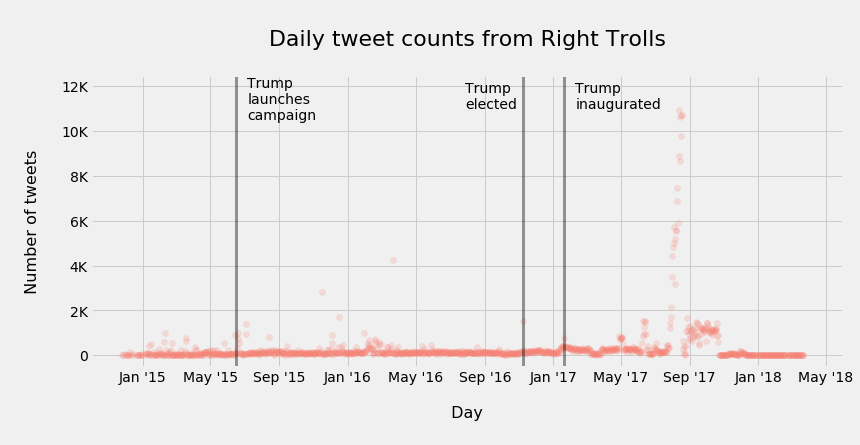

In [0]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8, bottom=0.2, left=0.1)

# Converter to convert date strings to datetime objects
conv = np.vectorize(mdates.strpdate2num('%Y-%m-%d'))

data = tweets_by_date_bots

# plt.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='salmon')
ax.set_title('\n Daily tweet counts from Right Trolls \n',
             size=22)
ax.set_xlabel('\n Day \n', size=16)
ax.set_ylabel('\n Number of tweets \n', size=16)
ax.set_ylim(-500, 12500)
ax.set_yticks(range(0, 14000, 2000))
ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])
ax.set_xlim(conv('2014-10-01'), conv('2018-06-01'))

month_yr_fmt = mdates.DateFormatter("%b '%y")
ax.xaxis.set_major_formatter(month_yr_fmt)


plt.axvline(conv('2015-06-16'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2015-06-16') + 20, 10500, 'Trump\nlaunches\ncampaign')
plt.axvline(conv('2016-11-8'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2016-07-8') + 20, 11000, 'Trump\nelected')
plt.axvline(conv('2017-01-20'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2017-01-20') + 20, 11000, 'Trump\ninaugurated')
plt.savefig('../../results/img/00_tweets_by_date_bots.png')

In [0]:
tweets_by_date_verified = pd.read_csv('../../data/06_reporting/tweets_by_date_verified.csv', parse_dates=[0])
print(tweets_by_date_verified.shape)
tweets_by_date_verified.head()

(1110, 2)


publish_date  num_of_tweets
0   2014-12-18             26
1   2014-12-19             18
2   2014-12-20              7
3   2014-12-21             10
4   2014-12-22             12

c:\users\joey\learn-env2\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The strpdate2num class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use time.strptime or dateutil.parser.parse or datestr2num instead.
  import sys


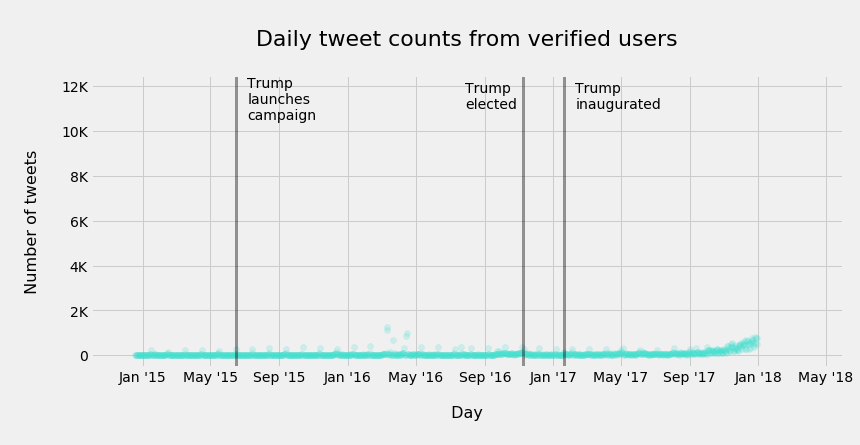

In [0]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.gcf().subplots_adjust(top=0.8, bottom=0.2, left=0.1)

# Converter to convert date strings to datetime objects
conv = np.vectorize(mdates.strpdate2num('%Y-%m-%d'))

data = tweets_by_date_verified

# plt.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='turquoise')
ax.set_title('\n Daily tweet counts from verified users \n',
             size=22)
ax.set_xlabel('\n Day \n', size=16)
ax.set_ylabel('\n Number of tweets \n', size=16)
ax.set_ylim(-500, 12500)
ax.set_yticks(range(0, 14000, 2000))
ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])
ax.set_xlim(conv('2014-10-01'), conv('2018-06-01'))

month_yr_fmt = mdates.DateFormatter("%b '%y")
ax.xaxis.set_major_formatter(month_yr_fmt)


plt.axvline(conv('2015-06-16'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2015-06-16') + 20, 10500, 'Trump\nlaunches\ncampaign')
plt.axvline(conv('2016-11-8'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2016-07-8') + 20, 11000, 'Trump\nelected')
plt.axvline(conv('2017-01-20'), color='black', alpha=0.4, linewidth=3)
plt.text(conv('2017-01-20') + 20, 11000, 'Trump\ninaugurated')
plt.savefig('../../results/img/01_tweets_by_date_verified.png')

#### Explore top hashtags

In [0]:
generate_hashtags_counts(right_trolls, new_filepath='../../data/06_reporting/hashtags_counts_bots.csv')

Processing all hashtags into one list...
...done.
List of all hashtags has length 262827
  Saved ../../data/06_reporting/hashtags_counts_bots.csv with shape (19232, 2)


In [0]:
top_hashtags_bots = pd.read_csv('../../data/06_reporting/hashtags_counts_bots.csv')
print(top_hashtags_bots.shape)
top_hashtags_bots.head(50)

(19232, 2)


hashtag  counts
0                 #top    6237
1                #MAGA    5426
2                 #mar    4666
3          #IslamKills    3841
4                #topl    3820
5                #tcot    3355
6               #PJNET    3328
7                 #amb    2749
8          #DemnDebate    2278
9                  #th    2122
10          #GOPDebate    2097
11                #may    2046
12          #DemDebate    1943
13           #FAKENEWS    1873
14           #Brussels    1869
15      #WakeUpAmerica    1691
16     #VegasGOPDebate    1667
17                #jud    1638
18                 #2A    1559
19          #StopIslam    1476
20               #USFA    1429
21                #imo    1393
22               #ccot    1345
23              #vvmar    1345
24               #marv    1345
25         #TrumpTrain    1302
26              #Trump    1274
27               #TCOT    1216
28               #ells    1214
29               #ella    1214
30               #CCOT    1211
31  #TrumpForPresident    1199
32          #Trump2016    1111
33                #law    1108
34               #laww    1107
35             #danita    1096
36             #dannis    1096
37                #job    1090
38               #jobb    1088
39               #just    1075
40                #iva    1073
41                 #iv    1073
42               #evas    1025
43              #eevan    1025
44               #arre    1014
45                #ara    1014
46                #jan    1001
47              #pjnet     987
48               #alis     965
49                #lis     965

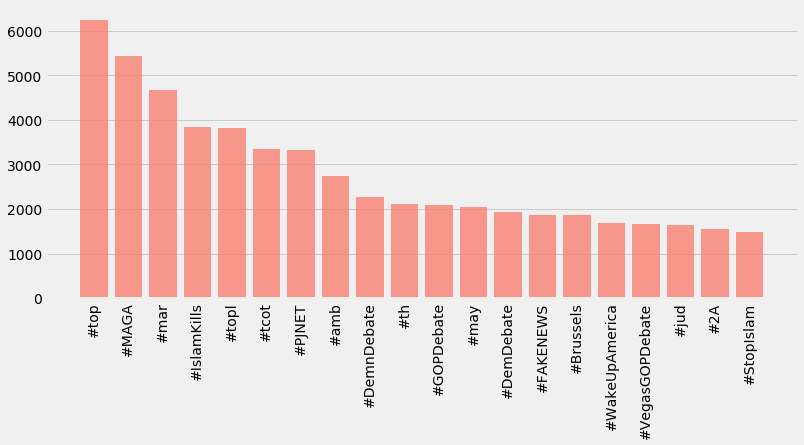

In [0]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
# plt.gcf().subplots_adjust(top=0.85, bottom=0.15)
# plt.gca().invert_yaxis()

data = top_hashtags_bots.set_index('hashtag').head(20)

ax.bar(data.index, data.counts, color='salmon', alpha=0.8)
ax.grid(b=False, axis='x')
ax.set_xticklabels(data.index, rotation=90);
# ax.scatter(data.publish_date, data.num_of_tweets, alpha=0.2, color='firebrick')
# ax.set_title('\n Daily tweet counts from Right Trolls \n',
#              size=22)
# ax.set_xlabel('\n Day \n', size=16)
# ax.set_ylabel('\n Number of tweets \n', size=16)
# ax.set_ylim(-500, 12500)
# ax.set_yticks(range(0, 14000, 2000))
# ax.set_yticklabels([0, '2K', '4K', '6K', '8K', '10K', '12K'])

#### Word clouds

In [0]:
def generate_data_for_wordclouds(df):
    """
    Generate input data for word clouds.
    
    Parameters
    ----------
        df : a dataframe of all tweets (must contain a field called "target")
        
    Returns
    -------
        text_all_trolls, text_all_verified
    """
    words_all_trolls = tweets_all[tweets_all.target == 1]
    words_all_verified = tweets_all[tweets_all.target == 0]
    text_all_trolls = " ".join(words_all_trolls.content_tokenized_lemma_joined.tolist())
    text_all_verified = " ".join(words_all_verified.content_tokenized_lemma_joined.tolist())
    
    return text_all_trolls, text_all_verified

In [0]:
def plot_word_cloud(data, colormap, new_filepath):
    """
    Plot a word cloud with a specified colormap.
    
    Parameters
    ----------
        data : text data to use in the word cloud (string)
        colormap : the color scheme to use in the word cloud
        new_filepath : the name and path of save the image
    
    Returns
    -------
        None. 
        
    """
    wordcloud = WordCloud(width=800, height=480, margin=0,
                          max_words=300, background_color="white",
                          colormap=colormap
                           ).generate(data)

    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.savefig(new_filepath)
    print('Saved ', new_filepath)
    plt.show()

In [7]:
tweets_all = pd.read_pickle('drive/My Drive/data/tweets_all_feats.pkl')
tweets_all.shape

(343582, 18)

Saved  drive/My Drive/data/02_word_cloud_trolls.png


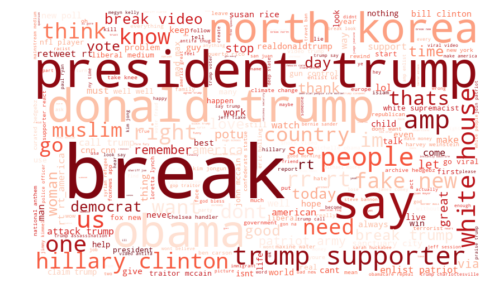

In [10]:
text_all_trolls, text_all_verified = generate_data_for_wordclouds(tweets_all)
plot_word_cloud(text_all_trolls, colormap='Reds', new_filepath='drive/My Drive/data/02_word_cloud_trolls.png')

Saved  drive/My Drive/data/03_word_cloud_verified.png


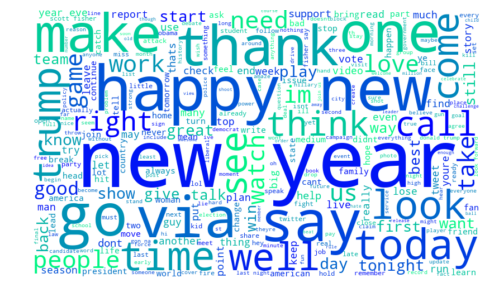

In [11]:
plot_word_cloud(text_all_verified, colormap='winter', new_filepath='drive/My Drive/data/03_word_cloud_verified.png')

#### Explore tweet predictions using `bokeh`

In [43]:
# generate_data_for_bokeh(path_to_data='drive/My Drive/data/predictions.csv', 
#                         new_filepath='drive/My Drive/data/data_for_bokeh.csv')

Original shape:  (18937, 8)
New shape:  (18937, 6)
Saved drive/My Drive/data/data_for_bokeh.csv


In [45]:
plot_bokeh_explore_predictions(path_to_data='drive/My Drive/data/data_for_bokeh.csv',
                               new_filepath='drive/My Drive/data/06_explore_tweet_predictions.html')

Saved drive/My Drive/data/06_explore_tweet_predictions.html
